In [1]:
import os
import cv2
import numpy as np

img_width = 224

# load data
label_cnt, X, y = 0, [], []
for folder in os.listdir("data/dataset"):

    print('loading: {0}'.format(folder))

    for filename in os.listdir("data/dataset/" + str(folder)):
        img = cv2.imread("data/dataset/" + str(folder) + '/' + str(filename))

        # resize and append
        X.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (img_width, img_width)))
        y.append(label_cnt)

    # new label for new folder
    label_cnt += 1

loading: car
loading: suv
loading: truck


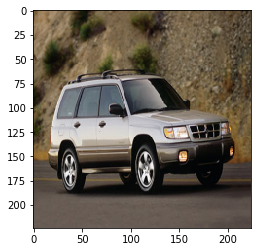

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# show random image from set
rand = np.random.randint(0, len(X))
imgplot = plt.imshow(X[rand])
plt.show()

In [3]:
import warnings
warnings.filterwarnings('ignore')

# scale and cast to np array as float32
X = (np.array(X) / 255).astype(np.float32)
y = np.array(y)

from keras.utils import to_categorical

# shuffle
np.random.seed(42)
shuffle_index = np.random.permutation(len(X))
X, y = X[shuffle_index], y[shuffle_index]

# split train and test data
train_size = 0.8
idx = int(train_size*X.shape[0])
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, label_cnt)
y_test = to_categorical(y_test, label_cnt)

print("train: {0} | test: {1}".format(X_train.shape[0], X_test.shape[0]))

Using TensorFlow backend.


train: 2920 | test: 730


In [4]:
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D

# reconstructing VGG19 model
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_width, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# load pretrained weights
model.load_weights('models/vgg19_weights.h5')

# freeze the pretrained layers
for layer in model.layers[:5]:
    layer.trainable = False

In [5]:
# adding custom layers 
model.add(Flatten())
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2048, activation="relu"))
model.add(Dense(label_cnt, activation="softmax"))

# compiling the model
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation for training
datagen = ImageDataGenerator(width_shift_range=0.2, 
                             height_shift_range=0.2,  
                             horizontal_flip=True)

datagen.fit(X_train)

# Train the model 
model.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                    epochs = 35,
                    shuffle=True)


print('Test accuracy: {0:.3}%'.format(model.evaluate(x=X_test, y=y_test, batch_size=16)[1] * 100))

# save model
model.save('models/vgg_retrained.h5')

Epoch 1/35
183/183 [==============================] - 34s 186ms/step - loss: 0.9380 - acc: 0.5700
Epoch 2/35
183/183 [==============================] - 31s 169ms/step - loss: 0.7061 - acc: 0.7066
Epoch 3/35
183/183 [==============================] - 31s 168ms/step - loss: 0.6397 - acc: 0.7452
Epoch 4/35
183/183 [==============================] - 31s 170ms/step - loss: 0.5323 - acc: 0.7848
Epoch 5/35
183/183 [==============================] - 31s 170ms/step - loss: 0.4733 - acc: 0.8156
Epoch 6/35
183/183 [==============================] - 31s 170ms/step - loss: 0.4255 - acc: 0.8419
Epoch 7/35
183/183 [==============================] - 31s 170ms/step - loss: 0.4104 - acc: 0.8381
Epoch 8/35
183/183 [==============================] - 31s 169ms/step - loss: 0.3674 - acc: 0.8607
Epoch 9/35
183/183 [==============================] - 31s 170ms/step - loss: 0.3647 - acc: 0.8596
Epoch 10/35
183/183 [==============================] - 31s 170ms/step - loss: 0.3089 - acc: 0.8794
Epoch 11/35
183/183

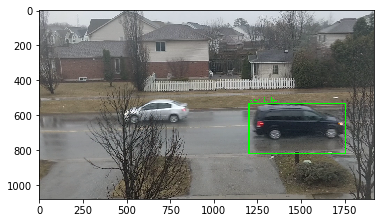

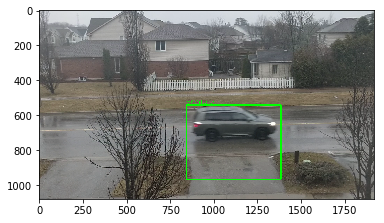

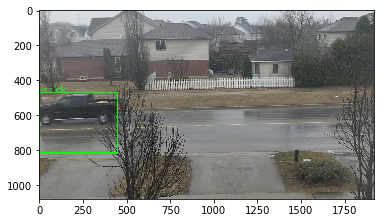

In [7]:
# load video
cap = cv2.VideoCapture('data/cars_passing_2.mp4')
fgbg = cv2.createBackgroundSubtractorMOG2()

end = False
count = 0
while not end:
    flag, frame = cap.read()

    # end of video 
    if not flag:
        break

    # apply motion subtactor to frame
    fgmask = fgbg.apply(frame)
    
    # find contours of moving object
    img2, cnts, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cont_sorted = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    # bound to box
    for cont in cont_sorted:
        if cont.shape[0] > 1000:
            x,y,w,h = cv2.boundingRect(cont)
            if w // h < 2 and w*h > 100000:

                # classify frame
                crop = frame[y:y+h,x:x+h,:]
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                crop = cv2.resize(crop, (224, 224))
                crop = np.expand_dims(crop, axis=0)
                pred = model.predict((crop / 255).astype(np.float16))[0]

                # draw box
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),5)
                cv2.putText(frame, "vehicle" , (x,y - 5), fontFace=2, fontScale=1.5, color=(0, 255, 0))

                count += 1
                if count % 20 == 0:
                    imgplot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    plt.show()

    # escape key will leave the window
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        end = True

cap.release()
cv2.destroyAllWindows()